# 以天氣與地理因子預測臺灣太陽能日發電量
Han-Sheng Huang  
2022

## 動機
隨著永續和環保的概念興起，世界各地都積極發展再生能源。以台灣來說，也有提出2025年，再生能源要佔總發電量的兩成的目標。  台灣地處亞熱帶，太陽能發電是發展再生能源的重點，以2020的台電資料來看，太陽能發電已經佔了再生能源發電的四成。  
不過，要將太陽能併入現有電網是有困難的，因為太陽能發電容易受天氣波動，很有可能會造成整體供電系統不穩，所以預測太陽能發電並做出適時因應是很重要的。因此，這篇報告的目的就是希望可以精準預測發電效率，並且找出影響發電效率的因子，使電力從業人員順暢調度能源並穩定電網。

## 資料來源

[台灣電力公司_風力及太陽光電發電量](https://data.gov.tw/dataset/17140)：取自臺灣政府資料開放平臺  
[台灣電力公司_太陽光電發電量及平均單位裝置容量每日發電量統計表](https://data.gov.tw/dataset/29938)：取自臺灣政府資料開放平臺  
[測站天氣資料](https://opendata.cwa.gov.tw/dataset/observation?page=1)：取自臺灣交通部中央氣象局觀測資料查詢平台  


## 分析過程

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.ensemble import GradientBoostingRegressor

from matplotlib import font_manager
my_font=font_manager.FontProperties(fname="msjhl.ttc")

import glob

In [2]:
capacity = pd.read_excel('台灣電力公司_太陽光電發電量及平均單位裝置容量每日發電量統計表.xlsx')
capacity

,年度/Year,月份/Month,發電站名稱/Station Name,裝置容量(瓩)/Installed Capacity(kW),發電量(度)/Power Generation(kW-h),平均單位裝置容量每日發電量/Average of Each Unit Power Generatioon Per Day,chinese_name,english_name
0,2016.0000,1.0000,大潭電廠光電/Datang Photovoltaics,651.4200,28418.0000,1.4100,大潭電廠光電,Datang Photovoltaics
1,2016.0000,1.0000,中大DS光電/Zhongda Photovoltaics,40.2500,1642.0000,1.3200,中大DS光電,Zhongda Photovoltaics
2,2016.0000,1.0000,中部儲運中心光電/Zhongchu Photovoltaics,91.8000,4805.0000,1.6900,中部儲運中心光電,Zhongchu Photovoltaics
3,2016.0000,1.0000,東勢新伯公光電/Xinbogong Photovoltaics,115.8000,5391.0000,1.5000,東勢新伯公光電,Xinbogong Photovoltaics
4,2016.0000,1.0000,卓蘭會館光電/Zhuolan Photovoltaics,41.9000,2660.0000,2.0500,卓蘭會館光電,Zhuolan Photovoltaics
...,...,...,...,...,...,...,...,...
1600,2021.0000,10.0000,平鎮淨水場光電/Pingzhen Water Treatment Plant Photovo...,1167.3600,109094.0000,3.0146,平鎮淨水場光電,Pingzhen Water Treatment Plant Photovoltaics
1601,2021.0000,10.0000,大湳淨水場光電/Dayan Water Treatment Plant Photovoltaics,860.1600,85111.0000,3.1919,大湳淨水場光電,Dayan Water Treatment Plant Photovoltaics
1602,2021.0000,10.0000,龜山加壓站光電/Guishan Booster Station Photovoltaics,307.2000,29605.0000,3.1087,龜山加壓站光電,Guishan Booster Station Photovoltaics
1603,2021.0000,10.0000,淡水配水場光電/Danshui Water Distribution Station Pho...,307.2000,29186.0000,3.0647,淡水配水場光電,Danshui Water Distribution Station Photovoltaics


### 資料前處理

為了能夠有好的比較基準，因此在此會將每日發電量透過電廠的裝置容量轉換成發電效率，可以想像成將發電結果依照發電廠的規模進行正規化。
另外，由於資料中有部分電廠在前期尚未有營運資料，因此刪除尚未營運的資料再進行分析。

In [3]:
def delete_startingzero(station_name,dataset):
    dataset['time'] = pd.to_datetime(dataset['time'])
    dataset['年度/Year'] = dataset['time'].dt.year.astype(int)
    dataset['月份/Month'] = dataset['time'].dt.month.astype(int)
    sub_cap = capacity[capacity['chinese_name']==station_name]
    if sub_cap.shape[0]!= 0 :
        dataset = pd.merge(dataset, sub_cap[['年度/Year','月份/Month','裝置容量(瓩)/Installed Capacity(kW)']], on=['年度/Year','月份/Month'], how='left')

    dataset['power_efficiency']=dataset['power']/(dataset['裝置容量(瓩)/Installed Capacity(kW)']*24)
    dataset = dataset.drop(columns=['power','裝置容量(瓩)/Installed Capacity(kW)'])
    
    zero_power=[]
    for i in range(len(dataset)):
        if np.isnan(dataset.iloc[i]['power_efficiency']) or dataset.iloc[i]['power_efficiency']==0.0000:
            zero_power.append(i)
        else:
            break
            
#     print("Starting zero:\n",zero_power)
    nonzero_dataset=dataset.drop(labels=zero_power, axis=0)
    nonzero_dataset=nonzero_dataset.reset_index(drop=True)
    return nonzero_dataset 

針對天氣資料進行處理，如：刪除部分與時間相關的欄位（如最高氣溫時間、最高氣壓時間）、將微量值設為0.05mm、刪除空值達 ½ 以上的欄或列

In [4]:
def preprocessing(dataset):
    time_cloumn=["time","StnPresMaxTime","StnPresMinTime","T Max Time","T Min Time","RHMinTime","WGustTime","PrecpMax10Time","PrecpMax60Time","UVI Max Time","年度/Year","月份/Month"]
    dataset = dataset.drop(columns=time_cloumn)

    dataset.insert(0, 'Converted_Time', range(len(dataset)))

    # 把有特殊符號的值轉成None
    for i in range(len(dataset.columns)):
        for j in range(len(dataset)):
            if dataset[dataset.columns[i]].iloc[j]=="&" or dataset[dataset.columns[i]].iloc[j]=="/" or \
                dataset[dataset.columns[i]].iloc[j]=="..." or dataset[dataset.columns[i]].iloc[j]=="X":
                dataset[dataset.columns[i]].iloc[j]=None
                
    # 把y值是null的row拿掉
    empty_y=[]
    for i in range(len(dataset)):
        if np.isnan(dataset['power_efficiency'].iloc[i]):
            empty_y.append(i)
    dataset=dataset.drop(labels=empty_y,axis=0)
    
    
    
    # 刪除column中有一半以上是「nan」的column
    useless_column=[]
    for i in range(len(dataset.columns)):
        if dataset.iloc[:,i].isna().sum()>=len(dataset)/2:
            useless_column.append(i)
    dataset=dataset.drop(columns=dataset.columns[useless_column])
    
    # 刪除row中有一半以上是「nan」的row
    useless_row=[]
    for i in range(len(dataset)):
        if dataset.iloc[i,:].isna().sum()>=len(dataset.columns)/2:
            useless_row.append(i)
    dataset=dataset.drop(labels=useless_row, axis=0)
                        
    
    # 把T的格子轉塞0.05        
    for i in range(len(dataset.columns)):
        for j in range(len(dataset)):
            if dataset[dataset.columns[i]].iloc[j]=="T":
                dataset[dataset.columns[i]].iloc[j]=0.05
                        
    
    # 所有column轉成numeric
    for i in range(len(dataset.columns)):
        dataset.iloc[:, i]=pd.to_numeric(dataset.iloc[:, i])
    
    return dataset, dataset.columns

可利用下方函式以相關係數進行特徵篩選

In [5]:
def featureselection_corr(dataset,draw_heatmap=False):
    for i in range(len(dataset.columns)):
        dataset.iloc[:, i]=pd.to_numeric(dataset.iloc[:, i])
    corr = dataset.corr()
    
    if draw_heatmap:
        # draw coor plot
        fig, ax = plt.subplots(figsize=(20,20)) 
        sb.heatmap(corr, annot=True)
    
    featrue_delete_list=[]
    for i in range(len(corr.columns)):
        if corr.columns[i]=='power_efficiency':
            continue
        for j in range(i+1,len(corr.columns)):
            if corr.columns[j]=='power_efficiency':
                continue
            if abs(corr[corr.columns[i]][corr.columns[j]])>0.75:
                if abs(corr['power_efficiency'][corr.columns[i]])>abs(corr['power_efficiency'][corr.columns[j]]):
                    temp_delete=corr.columns[j]
                else:
                    temp_delete=corr.columns[i]
                if temp_delete not in featrue_delete_list:
                    featrue_delete_list.append(temp_delete)
                    
    remained_feature=[item for item in dataset.columns if item not in featrue_delete_list]
    
    selected_dataset=dataset[remained_feature]
    
    return remained_feature, selected_dataset

將故障、風向不定、不明等資料利用 KNN 補值並且對資料做 Min-Max Normalization

In [6]:
def SplitNormalizeImpute(dataset):
    X = dataset.drop(["power_efficiency"], axis=1)
    y = dataset["power_efficiency"]
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
    X = scaler.transform(X)
    # print('Missing: %d' % sum(np.isnan(X).flatten()))
    imputer=KNNImputer(n_neighbors=5)
    imputer.fit(X)
    X=imputer.transform(X)
    # print('Missing: %d' % sum(np.isnan(X).flatten()))
    
    return X,y

### 模型預測
此份報告共使用四種預測模型，分別是Linear Regression、Random Forest、KNN、Gradient Boosting Decision Tree (GBDT)。  
並且使用五種衡量指標：Score(coefficient of determination)、MSE、RMSE、MAE、SMAPE

In [7]:
def linearregression(X_train, y_train, X_test, y_test):
    
    LinearRegressor=LinearRegression(fit_intercept=True)
    LinearRegressor.fit(X_train, y_train)
    score = LinearRegressor.score(X_test, y_test)

    y_pred = LinearRegressor.predict(X_test)
    mse=mean_squared_error(y_test, y_pred)
    rmse=mean_squared_error(y_test, y_pred, squared=False)
    smape=smape_calculate(y_test,y_pred)
    mae=mean_absolute_error(y_test, y_pred)
    
    return score, mse, rmse, smape, mae


In [8]:
def randomforestregression(X_train, y_train, X_test, y_test):

    RFRegressor = RandomForestRegressor(random_state=87)
    RFRegressor.fit(X_train, y_train)
    score = RFRegressor.score(X_test, y_test)

    y_pred = RFRegressor.predict(X_test)
    mse=mean_squared_error(y_test, y_pred)
    rmse=mean_squared_error(y_test, y_pred, squared=False)
    smape=smape_calculate(y_test,y_pred)
    mae=mean_absolute_error(y_test, y_pred)

    return score, mse, rmse, smape, mae, RFRegressor.feature_importances_


In [9]:
def GBDTregression(X_train, y_train, X_test, y_test):

    GBDTRegressor = GradientBoostingRegressor(random_state=87,learning_rate=0.005, n_estimators=2000)
    GBDTRegressor.fit(X_train, y_train)
    score = GBDTRegressor.score(X_test, y_test)

    y_pred = GBDTRegressor.predict(X_test)
    mse=mean_squared_error(y_test, y_pred)
    rmse=mean_squared_error(y_test, y_pred, squared=False)
    smape=smape_calculate(y_test,y_pred)
    mae=mean_absolute_error(y_test, y_pred)

    return score, mse, rmse, smape, mae, GBDTRegressor.feature_importances_


In [10]:
def KNNRegression(X_train, y_train, X_test, y_test):

    KNNRegressor = KNeighborsRegressor(n_neighbors=15)
    KNNRegressor.fit(X_train, y_train)
    score = KNNRegressor.score(X_test, y_test)

    y_pred = KNNRegressor.predict(X_test)
    mse=mean_squared_error(y_test, y_pred)
    rmse=mean_squared_error(y_test, y_pred, squared=False)
    smape=smape_calculate(y_test,y_pred)
    mae=mean_absolute_error(y_test, y_pred)

    return score, mse, rmse, smape, mae


In [11]:
def smape_calculate(a, f):
    return 1/len(a) * np.sum(2*np.abs(f-a)/(np.abs(a)+np.abs(f))*100)

In [12]:
powerplant=glob.glob('raw_data_CompleteWeather/*.csv')
# powerplant=glob.glob('raw_data/*.csv')
# powerplant

In [13]:
### histogram drawing

plantname_list=[]
remained_feature_list=[]
survived_column_list=[]
y_list=[]

for i in range(len(powerplant)):
    # Row_data
    # plantname=powerplant[i][9:]
    
    # Complete Weather data
    plantname=powerplant[i][25:]
    plantname=plantname.split('.')[0]
    plantname_list.append(plantname)
    # print(plantname)

    station_name=plantname
    dataset = pd.read_csv(powerplant[i])
    nonzero_dataset=delete_startingzero(station_name,dataset)
    preprocessed_dataset, survived_columns=preprocessing(nonzero_dataset)
    X,y=SplitNormalizeImpute(preprocessed_dataset)
    # print(len(y))
    y_list.append(y)
    

根據發電效率繪製出長條圖，觀看資料分佈情形

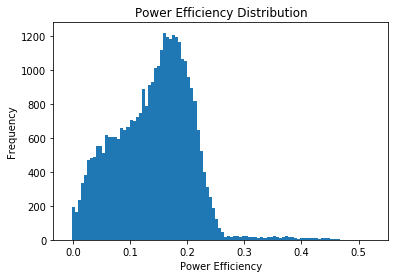

In [14]:
y_all=y_list[0]

for i in range(1,len(y_list)):
    y_all=pd.concat([y_all,y_list[i]])

plt.hist(y_all,bins=100)
plt.title("Power Efficiency Distribution")
plt.ylabel("Frequency")
plt.xlabel("Power Efficiency")
plt.show()

In [15]:
### predict

lg_score_list=[]
lg_mse_list=[]
lg_rmse_list=[]
lg_smape_list=[]
lg_mae_list=[]

rf_score_list=[]
rf_mse_list=[]
rf_rmse_list=[]
rf_smape_list=[]
rf_Importance_list=[]
rf_mae_list=[]

knn_score_list=[]
knn_mse_list=[]
knn_rmse_list=[]
knn_smape_list=[]
knn_mae_list=[]

GBDT_score_list=[]
GBDT_mse_list=[]
GBDT_rmse_list=[]
GBDT_smape_list=[]
GBDT_Importance_list=[]
GBDT_mae_list=[]

plantname_list=[]
remained_feature_list=[]
survived_column_list=[]

for i in range(len(powerplant)):
    
    # Row_data
    # plantname=powerplant[i][9:]
    
    # Complete Weather data
    plantname=powerplant[i][25:]
    plantname=plantname.split('.')[0]
    plantname_list.append(plantname)
    # print(plantname)

    station_name=plantname
    dataset = pd.read_csv(powerplant[i])
    nonzero_dataset=delete_startingzero(station_name,dataset)
    preprocessed_dataset, survived_columns=preprocessing(nonzero_dataset)
    # display(preprocessed_dataset.head(5))
    X,y=SplitNormalizeImpute(preprocessed_dataset)


    X_train,X_test,y_train,y_test=train_test_split(X, y, test_size = 0.2, random_state = 87)
    lg_score, lg_mse, lg_rmse, lg_smape, lg_mae=linearregression(X_train, y_train, X_test, y_test)
    rf_score, rf_mse, rf_rmse, rf_smape, rf_mae, rf_Importance=randomforestregression(X_train, y_train, X_test, y_test)
    knn_score, knn_mse, knn_rmse, knn_smape, knn_mae=KNNRegression(X_train, y_train, X_test, y_test)
    GBDT_score, GBDT_mse, GBDT_rmse, GBDT_smape, GBDT_mae, GBDT_Importance=GBDTregression(X_train, y_train, X_test, y_test)
    
    rf_Importance_list.append(rf_Importance)
    GBDT_Importance_list.append(GBDT_Importance)
    survived_column_list.append(survived_columns)
    
    lg_score_list.append(lg_score)
    lg_mse_list.append(lg_mse)
    lg_rmse_list.append(lg_rmse)
    lg_smape_list.append(lg_smape)
    lg_mae_list.append(lg_mae)
    
    rf_score_list.append(rf_score)
    rf_mse_list.append(rf_mse)
    rf_rmse_list.append(rf_rmse)
    rf_smape_list.append(rf_smape)
    rf_mae_list.append(rf_mae)
    
    knn_score_list.append(knn_score)
    knn_mse_list.append(knn_mse)
    knn_rmse_list.append(knn_rmse)
    knn_smape_list.append(knn_smape)
    knn_mae_list.append(knn_mae)
    
    GBDT_score_list.append(GBDT_score)
    GBDT_mse_list.append(GBDT_mse)
    GBDT_rmse_list.append(GBDT_rmse)
    GBDT_smape_list.append(GBDT_smape)
    GBDT_mae_list.append(GBDT_mae)

各電廠利用各模型預測出的各項指標如下：

In [16]:
casualtrain_outcome=pd.DataFrame(plantname_list)

df=pd.DataFrame(lg_score_list)
casualtrain_outcome=pd.concat([casualtrain_outcome,df],axis=1)
df=pd.DataFrame(lg_mse_list)
casualtrain_outcome=pd.concat([casualtrain_outcome,df],axis=1)
df=pd.DataFrame(lg_rmse_list)
casualtrain_outcome=pd.concat([casualtrain_outcome,df],axis=1)
df=pd.DataFrame(lg_mae_list)
casualtrain_outcome=pd.concat([casualtrain_outcome,df],axis=1)
df=pd.DataFrame(lg_smape_list)
casualtrain_outcome=pd.concat([casualtrain_outcome,df],axis=1)


df=pd.DataFrame(rf_score_list)
casualtrain_outcome=pd.concat([casualtrain_outcome,df],axis=1)
df=pd.DataFrame(rf_mse_list)
casualtrain_outcome=pd.concat([casualtrain_outcome,df],axis=1)
df=pd.DataFrame(rf_rmse_list)
casualtrain_outcome=pd.concat([casualtrain_outcome,df],axis=1)
df=pd.DataFrame(rf_mae_list)
casualtrain_outcome=pd.concat([casualtrain_outcome,df],axis=1)
df=pd.DataFrame(rf_smape_list)
casualtrain_outcome=pd.concat([casualtrain_outcome,df],axis=1)


df=pd.DataFrame(knn_score_list)
casualtrain_outcome=pd.concat([casualtrain_outcome,df],axis=1)
df=pd.DataFrame(knn_mse_list)
casualtrain_outcome=pd.concat([casualtrain_outcome,df],axis=1)
df=pd.DataFrame(knn_rmse_list)
casualtrain_outcome=pd.concat([casualtrain_outcome,df],axis=1)
df=pd.DataFrame(knn_mae_list)
casualtrain_outcome=pd.concat([casualtrain_outcome,df],axis=1)
df=pd.DataFrame(knn_smape_list)
casualtrain_outcome=pd.concat([casualtrain_outcome,df],axis=1)


df=pd.DataFrame(GBDT_score_list)
casualtrain_outcome=pd.concat([casualtrain_outcome,df],axis=1)
df=pd.DataFrame(GBDT_mse_list)
casualtrain_outcome=pd.concat([casualtrain_outcome,df],axis=1)
df=pd.DataFrame(GBDT_rmse_list)
casualtrain_outcome=pd.concat([casualtrain_outcome,df],axis=1)
df=pd.DataFrame(GBDT_mae_list)
casualtrain_outcome=pd.concat([casualtrain_outcome,df],axis=1)
df=pd.DataFrame(GBDT_smape_list)
casualtrain_outcome=pd.concat([casualtrain_outcome,df],axis=1)


casualtrain_outcome.columns=["Plant Name","lr_score","lr_mse","lr_rmse","lr_mae","lr_smape","rf_score","rf_mse","rf_rmse","rf_mae","rf_smape","knn_score","knn_mse","knn_rmse","knn_mae","knn_smape","GBDT_score","GBDT_mse","GBDT_rmse","GBDT_mae","GBDT_smape"]
casualtrain_outcome

,Plant Name,lr_score,lr_mse,lr_rmse,lr_mae,lr_smape,rf_score,rf_mse,rf_rmse,rf_mae,...,knn_score,knn_mse,knn_rmse,knn_mae,knn_smape,GBDT_score,GBDT_mse,GBDT_rmse,GBDT_mae,GBDT_smape
0,中大DS光電,0.8044,0.0008,0.0274,0.0199,22.4127,0.8278,0.0007,0.0257,0.0187,...,0.7966,0.0008,0.0280,0.0208,22.7703,0.8403,0.0006,0.0248,0.0181,19.4498
1,中科ES光電,0.8704,0.0003,0.0168,0.0122,9.5058,0.8845,0.0003,0.0159,0.0110,...,0.8145,0.0004,0.0202,0.0148,11.9123,0.8834,0.0003,0.0160,0.0112,8.5070
2,中部儲運中心光電,0.7523,0.0005,0.0232,0.0169,16.8300,0.7950,0.0004,0.0211,0.0150,...,0.7330,0.0006,0.0241,0.0182,18.5226,0.7869,0.0005,0.0215,0.0151,15.0511
3,北部儲運中心光電,0.9277,0.0003,0.0185,0.0103,9.6764,0.9201,0.0004,0.0195,0.0092,...,0.8945,0.0005,0.0224,0.0154,14.9060,0.9103,0.0004,0.0206,0.0103,8.6396
4,卓蘭會館光電,0.7382,0.0006,0.0242,0.0170,18.6254,0.7636,0.0005,0.0230,0.0159,...,0.6866,0.0007,0.0265,0.0190,21.1040,0.7711,0.0005,0.0226,0.0156,17.1549
5,南投大彎光電,0.8894,0.0003,0.0172,0.0139,13.4172,0.9223,0.0002,0.0144,0.0116,...,0.7608,0.0006,0.0253,0.0210,18.7659,0.9159,0.0002,0.0150,0.0120,9.2207
6,台中電廠GIS廠房光電,0.9221,0.0002,0.0126,0.0095,5.6071,0.9643,0.0001,0.0086,0.0073,...,0.8699,0.0003,0.0163,0.0132,8.4891,0.9464,0.0001,0.0105,0.0081,4.6554
7,台中電廠建物光電,0.9214,0.0002,0.0144,0.0100,5.0384,0.9481,0.0001,0.0117,0.0100,...,0.8439,0.0004,0.0203,0.0166,9.0784,0.9447,0.0001,0.0121,0.0098,4.8357
8,台南七股光電站,0.8453,0.0005,0.0225,0.0133,10.7869,0.8296,0.0006,0.0237,0.0144,...,0.7965,0.0007,0.0258,0.0172,14.4540,0.8616,0.0005,0.0213,0.0130,10.2250
9,台南鹽田光電,0.5132,0.0027,0.0518,0.0323,28.5037,0.8727,0.0007,0.0265,0.0195,...,0.5104,0.0027,0.0519,0.0353,32.4543,0.9054,0.0005,0.0228,0.0154,26.0379


In [17]:
from itertools import chain

remained_feature_list
unique, counts=np.unique(list(chain.from_iterable(remained_feature_list)),return_counts=True)
a=np.asarray((unique, counts)).T
a=a[a[:, 1].astype(int).argsort()]
np.flip(a)

array([], shape=(0, 2), dtype=float64)

In [18]:
# casualtrain_outcome.to_csv("TrainAll_Outcome.csv",encoding="utf_8_sig")
casualtrain_outcome.to_csv("DaySeperately_TrainAllOutcome_CompleteWeather.csv",encoding="utf_8_sig")

In [19]:
feature_column=['Converted_Time', 'StnPres', 'SeaPres', 'StnPresMax', 'StnPresMin',
                   'Temperature', 'T Max', 'T Min', 'Td dew point', 'RH', 'RHMin', 'WS',
                   'WD', 'WSGust', 'WDGust', 'Precp', 'PrecpHour', 'PrecpMax10',
                   'PrecpMax60', 'SunShine', 'SunShineRate', 'GloblRad', 'VisbMean',
                   'EvapA', 'UVI Max', 'Cloud Amount']

In [20]:
# Importance Calculation
rf_Importance_pd=pd.DataFrame(rf_Importance_list,columns=feature_column,index=plantname_list)
for i in range(len(rf_Importance_pd)):
    for j in range(len(rf_Importance_pd.iloc[0])):
        rf_Importance_pd.iloc[i,j]=np.nan
for i in range(len(rf_Importance_pd)):
    for j in range(len(rf_Importance_list[i])):
        feature_name=survived_column_list[i][j]
        rf_Importance_pd[feature_name][i]=rf_Importance_list[i][j]

rf_Importance_pd

,Converted_Time,StnPres,SeaPres,StnPresMax,StnPresMin,Temperature,T Max,T Min,Td dew point,RH,...,PrecpHour,PrecpMax10,PrecpMax60,SunShine,SunShineRate,GloblRad,VisbMean,EvapA,UVI Max,Cloud Amount
中大DS光電,0.0303,0.0026,0.0022,0.0046,0.0041,0.0065,0.0056,0.0075,0.0063,0.0122,...,0.0026,0.0018,0.0029,0.1287,0.0646,0.6422,0.0106,0.0097,0.0043,0.0087
中科ES光電,0.0100,0.0019,0.0019,0.0024,0.0020,0.0040,0.0099,0.0055,0.0044,0.0056,...,0.0019,0.0011,0.0012,0.0064,0.0058,0.8943,0.0043,0.0043,0.0036,0.0053
中部儲運中心光電,0.0889,0.0041,0.0039,0.0072,0.0084,0.0111,0.0136,0.0093,0.0098,0.0068,...,0.0030,0.0023,0.0021,0.0078,0.0082,0.7083,0.0114,0.0087,0.0054,0.0135
北部儲運中心光電,0.0058,0.0008,0.0011,0.0016,0.0010,0.0017,0.0020,0.0013,0.0015,0.0013,...,0.0029,0.0048,0.0063,0.0101,0.0061,0.9114,0.0034,0.0038,0.0047,0.0031
卓蘭會館光電,0.0763,0.0028,0.0033,0.0063,0.0041,0.0090,0.0070,0.0083,0.0062,0.0093,...,0.0045,0.0018,0.0025,0.1248,0.0248,0.6123,0.0135,0.0098,0.0041,0.0208
南投大彎光電,0.0191,0.0031,0.0029,0.0041,0.0047,0.0050,0.0246,0.0042,0.0044,0.0072,...,0.0097,0.0019,0.0016,0.0651,0.1119,0.6235,0.0080,0.0359,0.0210,0.0108
台中電廠GIS廠房光電,0.0038,0.0012,0.0009,0.0009,0.0010,0.0186,0.0081,0.0026,0.0014,0.0066,...,0.0025,0.0006,0.0005,0.1395,0.1554,0.6432,NaN,NaN,NaN,NaN
台中電廠建物光電,0.0026,0.0006,0.0008,0.0009,0.0017,0.0130,0.0082,0.0034,0.0016,0.0092,...,0.0032,0.0005,0.0004,0.1141,0.1442,0.6782,NaN,NaN,NaN,NaN
台南七股光電站,0.0120,0.0025,0.0019,0.0038,0.0027,0.0039,0.0075,0.0051,0.0102,0.0093,...,0.0038,0.0018,0.0023,0.2476,0.2019,0.4178,0.0101,NaN,0.0080,0.0083
台南鹽田光電,0.2829,0.0028,0.0043,0.0039,0.0051,0.0135,0.0505,0.0053,0.0068,0.0088,...,0.0022,0.0012,0.0018,0.2841,0.0303,0.1770,0.0399,NaN,0.0287,0.0168


In [21]:
rf_Importance_pd.to_csv("DaySeparately_RandomForestImportance_CompleteWeather.csv",encoding="utf_8_sig")

In [22]:
# Importance Calculation
GBDT_Importance_pd=pd.DataFrame(GBDT_Importance_list,columns=feature_column,index=plantname_list)
for i in range(len(GBDT_Importance_pd)):
    for j in range(len(GBDT_Importance_pd.iloc[0])):
        GBDT_Importance_pd.iloc[i,j]=np.nan
for i in range(len(GBDT_Importance_pd)):
    for j in range(len(GBDT_Importance_list[i])):
        feature_name=survived_column_list[i][j]
        GBDT_Importance_pd[feature_name][i]=GBDT_Importance_list[i][j]

GBDT_Importance_pd

,Converted_Time,StnPres,SeaPres,StnPresMax,StnPresMin,Temperature,T Max,T Min,Td dew point,RH,...,PrecpHour,PrecpMax10,PrecpMax60,SunShine,SunShineRate,GloblRad,VisbMean,EvapA,UVI Max,Cloud Amount
中大DS光電,0.0412,0.0004,0.0004,0.0015,0.0017,0.0018,0.0034,0.0034,0.0026,0.0071,...,0.0013,0.0016,0.0043,0.1805,0.0894,0.6174,0.0043,0.0016,0.0024,0.0083
中科ES光電,0.0121,0.0002,0.0015,0.0008,0.0010,0.0055,0.0127,0.0032,0.0023,0.0042,...,0.0018,0.0010,0.0006,0.0331,0.0076,0.8754,0.0022,0.0041,0.0009,0.0096
中部儲運中心光電,0.0976,0.0025,0.0023,0.0057,0.0038,0.0113,0.0217,0.0018,0.0025,0.0021,...,0.0014,0.0001,0.0000,0.0207,0.0050,0.7405,0.0083,0.0022,0.0052,0.0220
北部儲運中心光電,0.0093,0.0001,0.0002,0.0010,0.0004,0.0010,0.0016,0.0010,0.0005,0.0005,...,0.0034,0.0050,0.0054,0.0701,0.0075,0.8564,0.0018,0.0065,0.0086,0.0025
卓蘭會館光電,0.0926,0.0024,0.0017,0.0041,0.0013,0.0080,0.0051,0.0029,0.0013,0.0040,...,0.0027,0.0011,0.0015,0.1837,0.0074,0.6005,0.0075,0.0023,0.0012,0.0508
南投大彎光電,0.0320,0.0017,0.0042,0.0029,0.0025,0.0054,0.0341,0.0031,0.0056,0.0034,...,0.0182,0.0008,0.0013,0.0820,0.1078,0.6136,0.0061,0.0387,0.0060,0.0115
台中電廠GIS廠房光電,0.0059,0.0005,0.0005,0.0005,0.0012,0.0003,0.0022,0.0032,0.0007,0.0006,...,0.0011,0.0000,0.0000,0.0296,0.0532,0.8925,NaN,NaN,NaN,NaN
台中電廠建物光電,0.0055,0.0005,0.0004,0.0004,0.0005,0.0007,0.0008,0.0022,0.0005,0.0005,...,0.0005,0.0000,0.0000,0.0088,0.0202,0.9516,NaN,NaN,NaN,NaN
台南七股光電站,0.0227,0.0008,0.0016,0.0042,0.0034,0.0025,0.0032,0.0015,0.0148,0.0091,...,0.0013,0.0014,0.0009,0.1549,0.2903,0.4428,0.0045,NaN,0.0091,0.0067
台南鹽田光電,0.3798,0.0025,0.0019,0.0008,0.0033,0.0013,0.0649,0.0015,0.0050,0.0044,...,0.0017,0.0016,0.0010,0.3018,0.0759,0.1014,0.0176,NaN,0.0020,0.0075


In [23]:
GBDT_Importance_pd.to_csv("DaySeparately_GradientBoostingImportance_CompleteWeather.csv",encoding="utf_8_sig")

根據Random Forest和GBDT跑出的特徵重要性

Random Forest              | GBDT
:-------------------------:|:-------------------------:
![](RF_Importance.png)  |  ![](GBDT_Importance.png)

### 結論
* Random Forest與GBDT有接近的表現。若使用所有欄位來預測，平均 RMSE 皆可落在 2.2% ~ 2.3% 左右，若刪除彼此相關係數高的欄位之後來做預測，平均RMSE則可落在3.2% ~ 3.3%。  
* Linear Regression 和 KNN 的預測模型表現較差。
* 根據 Random Forest 與 GBDT 跑出的特徵重要性，陽光相關的天氣指標、時間、最小相對濕度、總雲量有較高的重要性。
* 本篇報告使用了日發電量資料找出了預測太陽能發電效率的重要指標。另外，預測結果可以提供不同地區的日發電效率預測，幫助決策者進行發電廠選址參考，以及透過預測的日發電效率，達到預警進而對發電板進行維護。